In [1]:
import random
import torch
from torch import nn
import torch.nn.functional as F

import numpy as np 

from sklearn.model_selection import train_test_split
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

random_seed = 1
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/gnn_auto')

from utils import load_data, prepare_data
from utils import compute_adj_matrices
from utils import get_dataloaders

from layers_batchwise_2 import GraphConvolution

from utils import init_model_params

from utils import train_model

from utils import model_predict

from utils import print_classification_report

from utils import plot_cm


In [2]:
X, y, label_map = load_data('../dataset/train/cross_subject_data_5_subjects.pickle')
class_names = list(label_map.keys())

seq_len = 100
X, y = prepare_data(X, y, seq_len, normalize=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y)


X original shape: (295008, 64)
y original shape: (295008,)
Seq len: 100
X conversion shape: (2950, 64, 100)
y conversion shape: (2950,)


In [3]:
A = compute_adj_matrices('s')
print(A)

64
[[0.         0.07259316 0.0377163  ... 0.         0.         0.        ]
 [0.07259316 0.         0.07242256 ... 0.         0.         0.        ]
 [0.0377163  0.07242256 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.10730997 0.10929675]
 [0.         0.         0.         ... 0.10730997 0.         0.09523205]
 [0.         0.         0.         ... 0.10929675 0.09523205 0.        ]]


In [4]:
batch_size = 32
dataloaders, dataset_sizes = get_dataloaders(X_train, y_train, X_test, y_test, batch_size)

In [24]:
in_features = seq_len
hidden_size_1 = 256
hidden_size_2 = 512
hidden_size_3 = 256
hidden_size_4 = 4
num_classes = 4
n_channels = 64

class GCN(nn.Module):
    def __init__(self, in_features, n_nodes, num_classes):
        super(GCN, self).__init__()
        self.gc1 = GraphConvolution(in_features, hidden_size_1, batch_size, n_channels)
        self.gc2 = GraphConvolution(hidden_size_1, hidden_size_2, batch_size, n_channels)
        self.gc3 = GraphConvolution(hidden_size_2, hidden_size_3, batch_size, n_channels)
        # self.gc4 = GraphConvolution(hidden_size_3, hidden_size_4, batch_size, n_channels)
        # self.flatten = nn.Flatten()
        # self.linear = nn.Linear(hidden_size_4*n_channels, num_classes)
        self.node_embeddings = nn.Parameter(torch.randn(n_nodes, n_nodes), requires_grad=True)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(hidden_size_3*n_channels, num_classes)

        self.node_embeddings = nn.Parameter(torch.randn(n_nodes, n_nodes), requires_grad=True)
    def forward(self, x):
        # print(x.shape)
        # A = F.softmax(F.relu(torch.mm(self.node_embeddings, self.node_embeddings.transpose(0, 1))), dim=1)
        # A = A + torch.eye(A.shape[0]).to(device)
        out = F.relu(self.gc1(x, self.node_embeddings))
        # print(out.shape)
        out = F.relu(self.gc2(out, self.node_embeddings))
        # print(out.shape)
        out = F.relu(self.gc3(out, self.node_embeddings))
        # print(out.shape)
        # out = F.relu(self.gc4(out, A))
        # print(out.shape)
        out = self.flatten(out)
        # print(out.shape)
        out = self.linear(out)
        # print(out.shape)
        return out


model = GCN(in_features=in_features, n_nodes=n_channels, num_classes=num_classes).to(device)


model = init_model_params(model)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())


# writer.add_graph(model, X_train[:batch_size])

In [30]:
n_nodes = 64
node_num = n_nodes
node_embeddings = nn.Parameter(torch.randn(n_nodes, n_nodes), requires_grad=True)

supports = F.softmax(F.relu(torch.mm(node_embeddings, node_embeddings.transpose(0, 1))), dim=1)

# support_set = [torch.eye(node_num).to(supports.device), supports]

# supports = torch.stack(support_set, dim=0)

# supports.shape

In [31]:
supports

tensor([[1.0000e+00, 1.1913e-18, 1.2362e-16,  ..., 9.8738e-19, 1.9627e-18,
         2.9142e-17],
        [1.7008e-35, 1.0000e+00, 9.8243e-28,  ..., 1.1655e-28, 1.4097e-35,
         1.4097e-35],
        [2.7297e-21, 1.5195e-15, 1.0000e+00,  ..., 4.6472e-23, 4.3676e-21,
         2.1803e-23],
        ...,
        [5.8648e-28, 4.8490e-21, 1.2501e-27,  ..., 1.0000e+00, 5.8648e-28,
         5.8648e-28],
        [1.1137e-25, 5.6028e-26, 1.1224e-23,  ..., 5.6028e-26, 1.0000e+00,
         5.6028e-26],
        [2.3880e-20, 8.0908e-22, 8.0908e-22,  ..., 8.0908e-22, 8.0908e-22,
         1.0000e+00]], grad_fn=<SoftmaxBackward>)

In [16]:
num_epochs = 100
train_model(dataloaders, dataset_sizes, model, criterion, optimizer, num_epochs, writer)

Epoch 0/99
----------
train Loss: 2.3946 Acc: 0.2453
val Loss: 1.5911 Acc: 0.2525

Epoch 1/99
----------
train Loss: 1.4058 Acc: 0.3462
val Loss: 1.4449 Acc: 0.2576

Epoch 2/99
----------
train Loss: 1.2459 Acc: 0.4242
val Loss: 1.5421 Acc: 0.2424

Epoch 3/99
----------
train Loss: 1.1786 Acc: 0.4614
val Loss: 1.4822 Acc: 0.2475

Epoch 4/99
----------
train Loss: 1.1257 Acc: 0.4894
val Loss: 1.5597 Acc: 0.2475

Epoch 5/99
----------
train Loss: 1.0188 Acc: 0.5538
val Loss: 1.7393 Acc: 0.2644

Epoch 6/99
----------
train Loss: 0.9012 Acc: 0.6119
val Loss: 1.9150 Acc: 0.2847

Epoch 7/99
----------
train Loss: 0.8030 Acc: 0.6606
val Loss: 1.9592 Acc: 0.2644

Epoch 8/99
----------
train Loss: 0.6859 Acc: 0.7072
val Loss: 2.0318 Acc: 0.2593

Epoch 9/99
----------
train Loss: 0.6266 Acc: 0.7373
val Loss: 2.2589 Acc: 0.2763

Epoch 10/99
----------
train Loss: 0.6067 Acc: 0.7568
val Loss: 2.5688 Acc: 0.2780

Epoch 11/99
----------
train Loss: 0.5947 Acc: 0.7458
val Loss: 2.5273 Acc: 0.2797

Ep

GCN(
  (gc1): GraphConvolution (100 -> 256)
  (gc2): GraphConvolution (256 -> 512)
  (gc3): GraphConvolution (512 -> 256)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=16384, out_features=4, bias=True)
)

<AxesSubplot:>

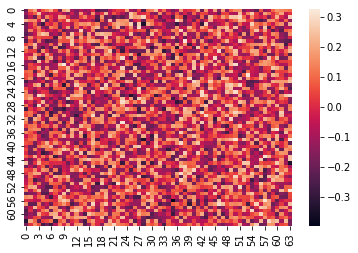

In [17]:
import seaborn as sns
sns.heatmap(model.node_embeddings.cpu().detach().numpy())

In [7]:
y_preds, y_test = model_predict(model, test_loader=dataloaders['val'])

In [8]:


cr, cm = print_classification_report(y_test, y_preds, num_classes, writer)

              precision    recall  f1-score   support

           0       0.31      0.35      0.33       142
           1       0.39      0.36      0.37       147
           2       0.38      0.40      0.39       149
           3       0.34      0.30      0.32       138

    accuracy                           0.35       576
   macro avg       0.35      0.35      0.35       576
weighted avg       0.36      0.35      0.35       576

[[50 39 28 25]
 [37 53 27 30]
 [39 24 60 26]
 [35 20 42 41]]
AUROC ovo: 0.5688889451805571
AUROC ovr: 0.5688889451805571


In [9]:


plot_cm(cm, class_names)

TypeError: plot_cm() missing 1 required positional argument: 'save_path'

In [ ]:
print('Number of trainable parameters')
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

Number of trainable parameters


358404